# Probabilistic Learning

<center><img src="images/bayes_net_example.png" width=50%></center>

In [1]:
# Importing the necessary libaries
import sys
sys.path.insert(0, "aux_functions")
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from scipy.fftpack import fft, fftfreq
%matplotlib inline

# Extension to reload functions
%load_ext autoreload
%autoreload 2
from vis_functions import *

# Loading the dataset
mitbih_test = pd.read_csv("datasets/heartbeat/mitbih_test.csv", header = None)
mitbih_train = pd.read_csv("datasets/heartbeat/mitbih_train.csv", header = None)

# Class dict
# These classes are the names of the wave forms
class_dict ={
    0.: 'N',
    1.: 'S',
    2.: 'V',
    3.: 'F',
    4.: 'Q'    
}

### Exploring the Data

The data is described as having 87554 examples for traning ang 21892 for testing. Each column holds an example and each cloumn one sample at a time.

The sample rate is 360Hz and each example has 1.5s of total measure time

In [2]:
sample_rate = 360

# Separating data and label from the test set
mitbih_test_X = mitbih_test.iloc[:, :-1]
mitbih_test_Y = mitbih_test.iloc[:, -1].to_frame()

# Separating data and label from the train set
mitbih_train_X = mitbih_train.iloc[:, :-1]
mitbih_train_Y = mitbih_train.iloc[:, -1].to_frame()

# Creating a time reference, every sample is considered starting
# at time 0
time_vec = np.arange(mitbih_test_X.T.shape[0]) * 1/sample_rate

print("mitbih_train_X shape:", mitbih_train_X.shape)
print("mitbih_train_Y shape:", mitbih_train_Y.shape)
print("mitbih_test_X shape:", mitbih_test_X.shape)
print("mitbih_test_Y shape:", mitbih_test_Y.shape)
mitbih_test_X.head(10)

mitbih_train_X shape: (87554, 187)
mitbih_train_Y shape: (87554, 1)
mitbih_test_X shape: (21892, 187)
mitbih_test_Y shape: (21892, 1)


,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.000000,0.923664,0.656489,0.195929,0.111959,0.175573,0.122137,0.050891,0.035623,0.055980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.000000,0.797260,0.320548,0.043836,0.049315,0.065753,0.030137,0.008219,0.005479,0.010959,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.909408,0.975610,0.533101,0.134146,0.066202,0.000000,0.010453,0.012195,0.031359,0.146341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.927803,0.866359,0.299539,0.000000,0.231951,0.317972,0.274962,0.262673,0.270353,0.268817,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.000000,0.914230,0.473684,0.000000,0.064327,0.317739,0.405458,0.391813,0.382066,0.401559,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
mitbih_test_Y["class_id"] = mitbih_test_Y.iloc[:, 0]
mitbih_test_Y["class_name"] = mitbih_test_Y.loc[:, "class_id"].apply(lambda x: class_dict[x])
mitbih_test_Y.drop(mitbih_test_Y.columns[0], axis = 1, inplace = True)
print("mitbih_test_Y shape:", mitbih_test_Y.shape)
mitbih_test_Y.head(10)

mitbih_test_Y shape: (21892, 2)


,class_id,class_name
0,0.0,N
1,0.0,N
2,0.0,N
3,0.0,N
4,0.0,N
5,0.0,N
6,0.0,N
7,0.0,N
8,0.0,N
9,0.0,N


### Raw Signal Visualization

First I'll separate the data into its respective classes and visualize each class separatelly. This process will help us understand the basic shapes and maybe come up with some strategy to tackle the problem.

In [4]:
# Separating the test data and label into its respective classes
N_mitbih_test_X = mitbih_test_X.loc[mitbih_test_Y["class_name"] == "N"]
S_mitbih_test_X = mitbih_test_X.loc[mitbih_test_Y["class_name"] == "S"]
V_mitbih_test_X = mitbih_test_X.loc[mitbih_test_Y["class_name"] == "V"]
F_mitbih_test_X = mitbih_test_X.loc[mitbih_test_Y["class_name"] == "F"]
Q_mitbih_test_X = mitbih_test_X.loc[mitbih_test_Y["class_name"] == "Q"]

N_mitbih_test_Y = mitbih_test_Y.loc[mitbih_test_Y["class_name"] == "N"]
S_mitbih_test_Y = mitbih_test_Y.loc[mitbih_test_Y["class_name"] == "S"]
V_mitbih_test_Y = mitbih_test_Y.loc[mitbih_test_Y["class_name"] == "V"]
F_mitbih_test_Y = mitbih_test_Y.loc[mitbih_test_Y["class_name"] == "F"]
Q_mitbih_test_Y = mitbih_test_Y.loc[mitbih_test_Y["class_name"] == "Q"]

#### N Wave Visualization

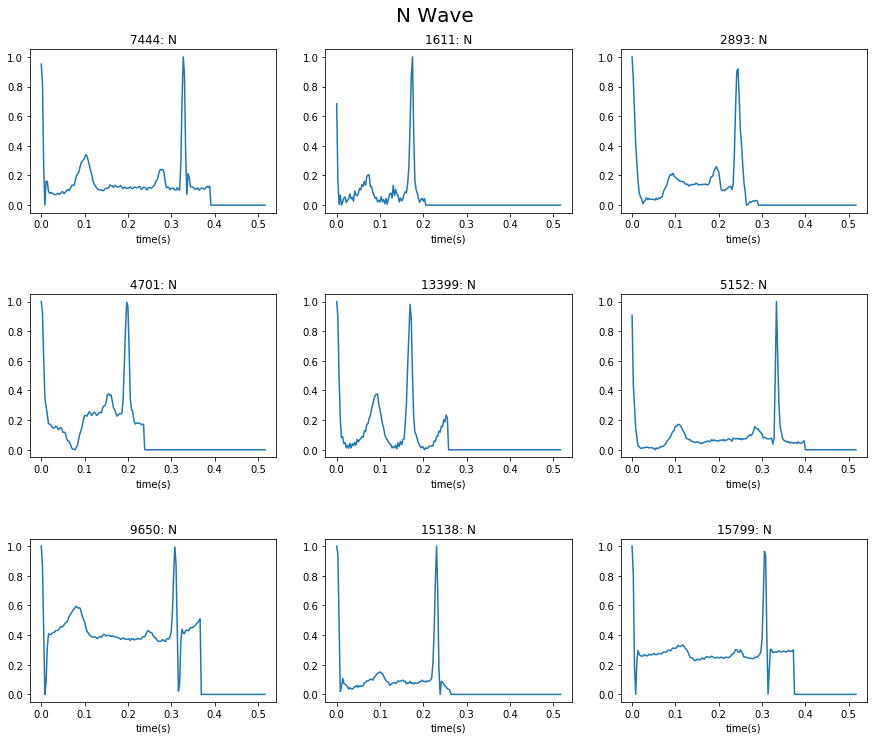

In [5]:
plot_random(N_mitbih_test_X.T, N_mitbih_test_Y, "time", "class_name").suptitle("N Wave", y = 0.93, fontsize = 20)
plt.show()

#### S Wave Visualization

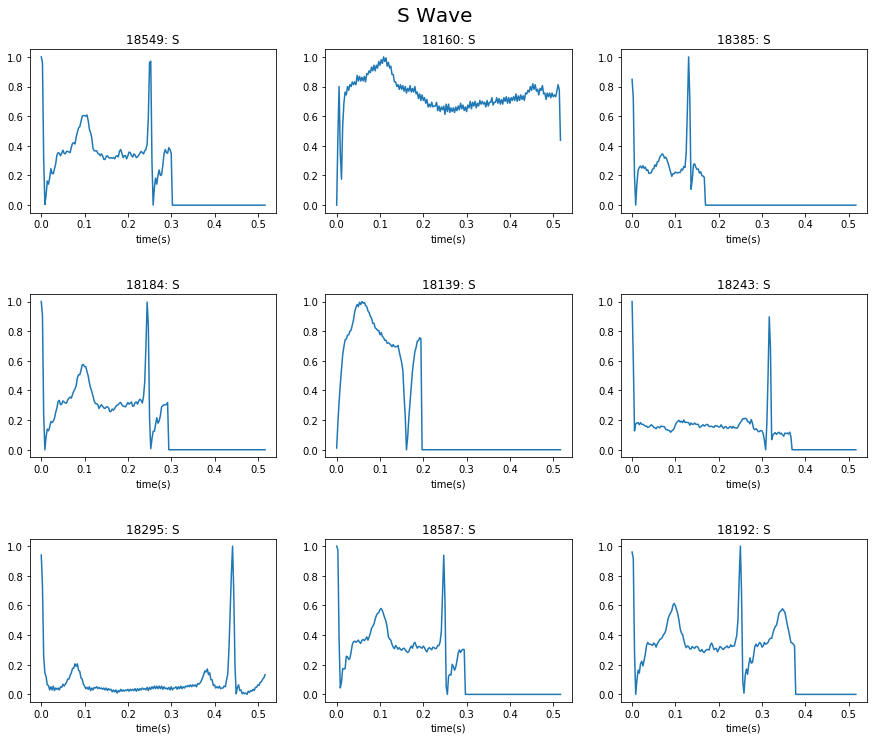

In [6]:
plot_random(S_mitbih_test_X.T, S_mitbih_test_Y, "time", "class_name").suptitle("S Wave", y = 0.93, fontsize = 20)
plt.show()

#### V Wave Visualization

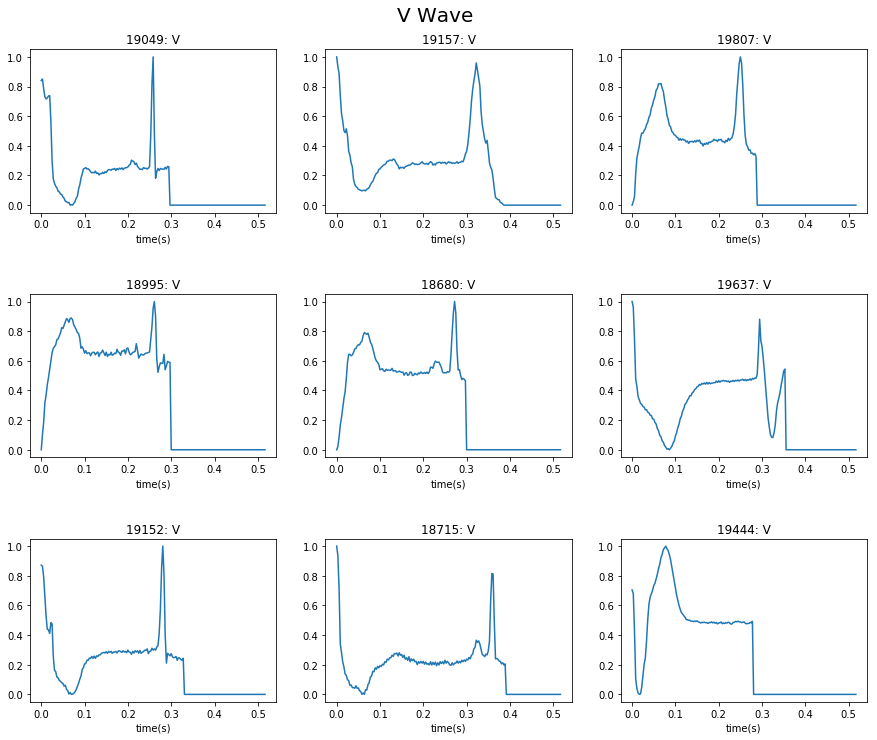

In [7]:
plot_random(V_mitbih_test_X.T, V_mitbih_test_Y, "time", "class_name").suptitle("V Wave", y = 0.93, fontsize = 20)
plt.show()

#### F Wave Visualization

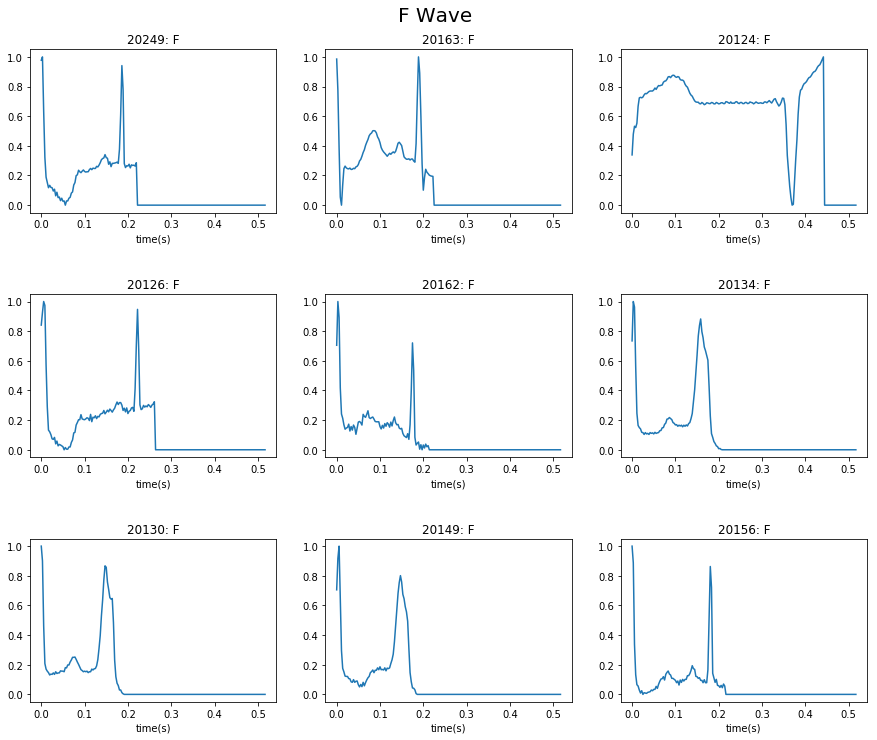

In [8]:
plot_random(F_mitbih_test_X.T, F_mitbih_test_Y, "time", "class_name").suptitle("F Wave", y = 0.93, fontsize = 20)
plt.show()

#### Q Wave Visualization

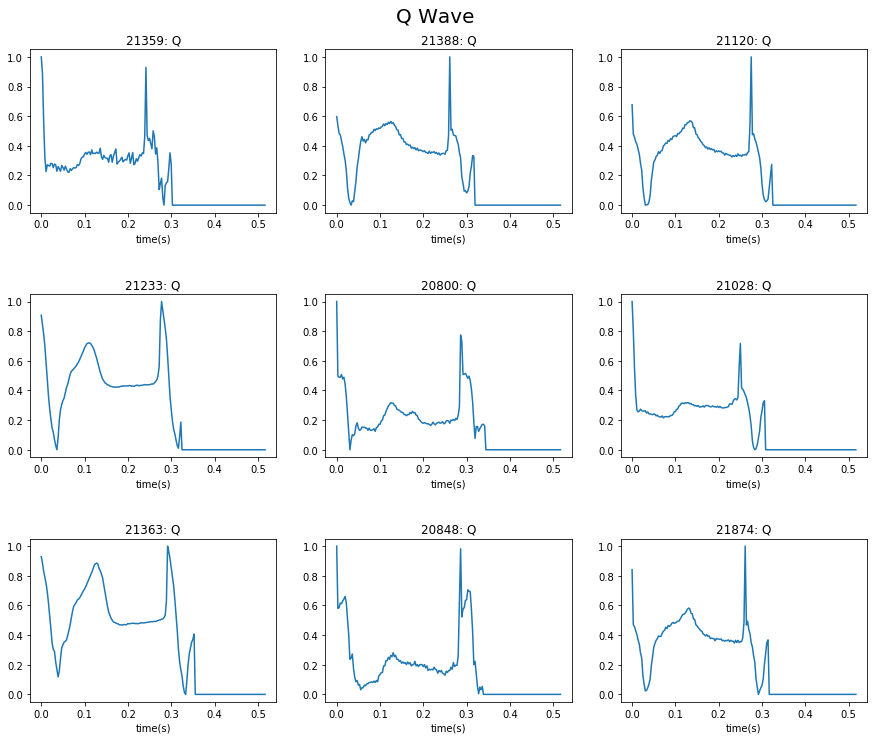

In [9]:
plot_random(Q_mitbih_test_X.T, Q_mitbih_test_Y, "time", "class_name").suptitle("Q Wave", y = 0.93, fontsize = 20)
plt.show()

### Frequency Domain Signal Analysis

/home/otavio/.conda/envs/dlpy36-tf/lib/python3.6/site-packages/matplotlib/mlab.py:1246: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=187).
  "(=%d) >= signal length (=%d)." % (NFFT, len(x)))


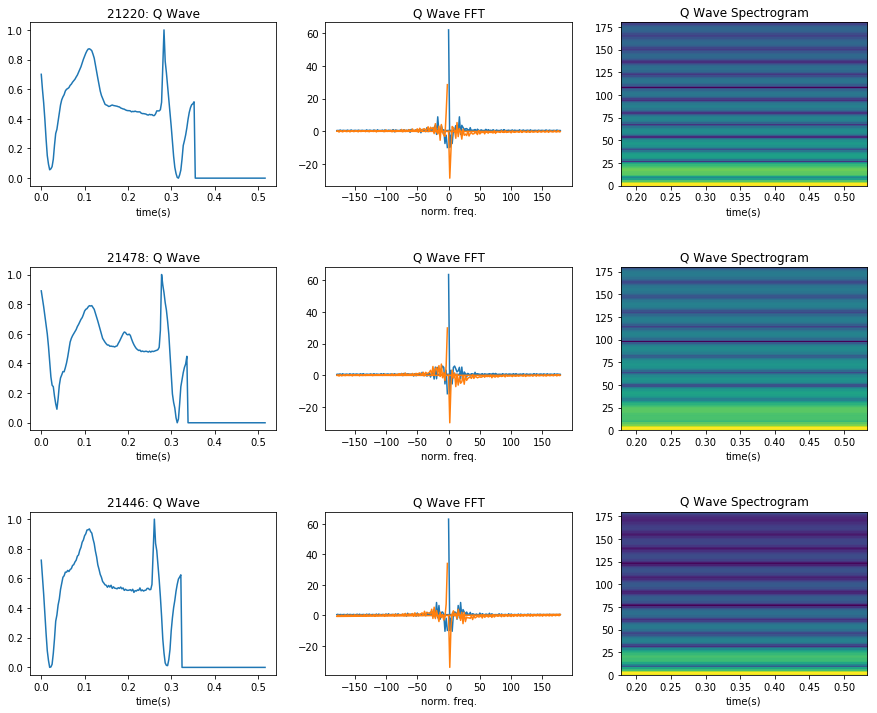

In [10]:
plot_fanalysis(Q_mitbih_test_X.T, Q_mitbih_test_Y, "time", "class_name", nplots = 3)
plt.show()

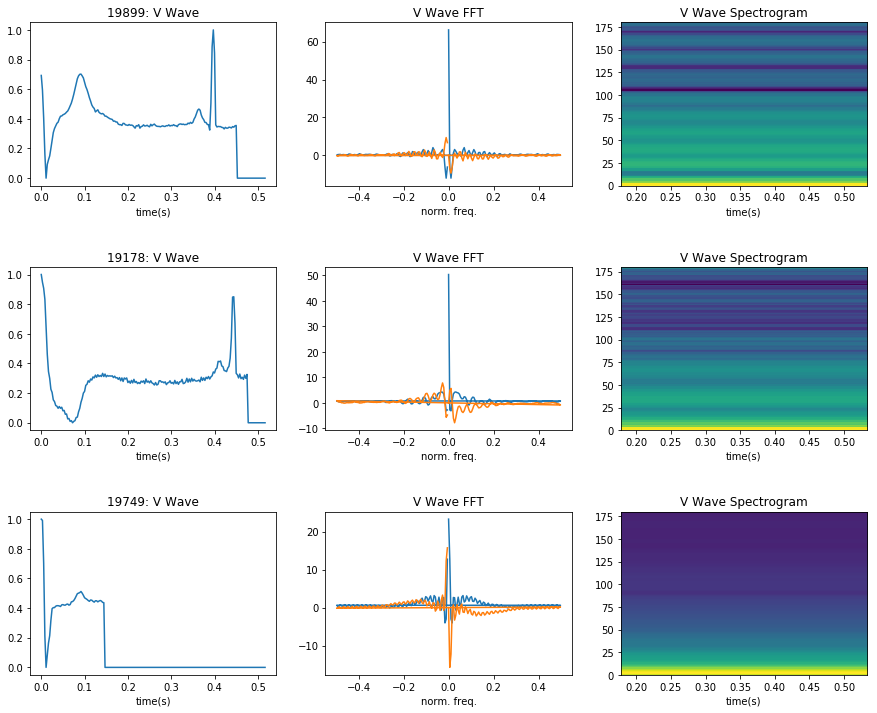

In [16]:
plot_fanalysis(V_mitbih_test_X.T, V_mitbih_test_Y, "time", "class_name", nplots = 3)
plt.show()